# Agtuary ML Challenge - Training

This notebook trains and evaluates a series of models as part of the [Agtuary ML Challenge](https://github.com/agtuary/machine-learning-challenge).

In this notebook I have developed a training pipeline consisting of the following steps:
1. A standard scaler to normalise input features between 0 and 1, which can be important for certain models such as neural networks
2. A stratified and shuffled K-fold cross validation strategy. Stratifying maintains the class balance, ensuring each fold is representative of the data, while shuffling ensures each fold contains members of each class. To keep runtime down only 5 folds are created with no repeats, although the variance between folds is minimal
3. A grid search over a limited number of hyperparameters for each model in order to keep runtime down. The search should probably be expanded in future to test new and different hyperparameter settings that could unlock performance gains.
4. An evaluation using 7 different metrics for imbalanced classification problems. The F1 score 'macro' is chosen as the selection metric as it provides a balance between variance and bias, and, I feel, provides the best representation of the confusion matrix on an imbalanced problem.

The cross validation evaluation table shows that the AdaBoost and stochastic gradient descent models are outperformed by the multilayer perceptron (MLP), random forest classifier (RFC) and the k-nearest neighbours classifier (KNN), which all perform comparably. A final evaluation on the test set (held out from the set used for cross validation) using confusion matrices shows that the MLP and RFC generalise better than the KNN. As the RFC has a slightly better Cohen-Kappa score, the RFC is chosen for use on an inference task in the next notebook.

In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer, fbeta_score, jaccard_score, cohen_kappa_score, matthews_corrcoef

import os
import glob
import pickle
import tarfile
import urllib.request

pd.options.mode.chained_assignment = None

In [3]:
def load_image(path):
    return np.array(PIL.Image.open(path))[:, :]

In [4]:
# make subfolder to store data
def make_subfolder(subfolder_path):
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)
        print(f"Created subfolder '{subfolder_path}'")
    else:
        print(f"Cannot create directory: '{subfolder_path}' already exists.")

In [5]:
def save_model(model, filename, folder):
    print(f"Checking if '{filename}' already exists in '{folder}'...")
    file_path = os.path.join(folder, filename)
    if os.path.exists(file_path) is True:
        print(f"Cannot save model: '{filename}' already exists.")
    else:
        print(f"Saving '{filename}' to '{file_path}'")
        with open(file_path, 'wb') as f:
            pickle.dump(model, f)
        print("Save complete.")

In [6]:
#set variable groups
bands = ['B01', 'B02', 'B03', 'B05', 'B06', 'B09', 'B11', 'B12']
indices = ['ndmi', 'gemi']
cloud_prob = ['cloud_prob']
label = ['label_id']

In [7]:
# get the current working directory
path = os.getcwd()
print(path)

/home/lachy/dml/agtuary-machine-learning-challenge-master


In [8]:
# get location of data subfolder
subfolder = "data_raw"
data_dir = os.path.join(path, subfolder)
print(data_dir)

/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw


In [9]:
#create models directory if doesn't exist
models_dir = os.path.join(path, "models")
make_subfolder(models_dir)

Cannot create directory: '/home/lachy/dml/agtuary-machine-learning-challenge-master/models' already exists.


In [10]:
# load data into dataframe
pixels = pd.read_csv(data_dir + "/pixels.csv")

In [11]:
# remove band B04 and any pixels with cloud prob > 2
df = pixels[pixels['cloud_prob'] <= 2].drop(columns=['B04'])

In [12]:
label_mapper = {0: 'Other', 1:'Sorghum', 2:'Cotton'}
label_mapper.values()

dict_values(['Other', 'Sorghum', 'Cotton'])

In [13]:
#NDMI index
def calc_ndmi(df):
    df['ndmi'] = (df.B08 - df.B11) / (df.B08 + df.B11)
    return df

In [14]:
#GEMI index
def calc_gemi(df):
    gemi_w = (2*(df.B09**2 - df.B05**2) + 1.5*df.B09 + 0.5*df.B05) / (df.B09 + df.B05 + 0.5)
    df['gemi'] = (gemi_w * (1 - 0.25*gemi_w) - (df.B05-0.125)/(1-df.B05))
    return df

In [15]:
def calc_indices(df):
    df = calc_ndmi(df)
    df = calc_gemi(df)
    return df

In [16]:
df = calc_indices(df)

In [17]:
df = df.drop(columns=['B07', 'B08', 'B8A'])

## Model Training

Pipeline: cross validation to select hyperparameters, comparison of optimised models on test set.

The F1-score is chosen as the evaluation metric for optimisation. It provides balance between recall and precision.

In [18]:
# split into train and test, validate
X, y = df[bands + indices], df.label_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [19]:
# scale and centre
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
save_model(scaler, 'scaler.sav', models_dir)

Checking if 'scaler.sav' already exists in '/home/lachy/dml/agtuary-machine-learning-challenge-master/models'...
Cannot save model: 'scaler.sav' already exists.


In [21]:
# cross validation strategy - shuffle data, choose 5 non-overlapping test sets
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fone_scorer = make_scorer(fbeta_score, beta=1, average='macro')
ftwo_scorer = make_scorer(fbeta_score, beta=2, average='macro')
jaccard_scorer = make_scorer(jaccard_score, average='macro')
kappa_scorer = make_scorer(cohen_kappa_score)
matt_scorer = make_scorer(matthews_corrcoef)

scoring = {'acc': 'accuracy',
           'f1_macro': fone_scorer,
           'f2_macro': ftwo_scorer,
           'rec_macro': 'recall_macro',
           'jaccard_macro': jaccard_scorer,
           'kappa_score': kappa_scorer,
           'matthews_score': matt_scorer}

In [22]:
def evaluate_model(model, X, y, scoring, cv, n_jobs):
    scores = cross_validate(estimator=model, X=X, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, return_train_score=False)
    test_scorers = ['test_' + x for x in scoring.keys()]
    evaluation_scores = pd.DataFrame.from_dict(scores).T.mean(axis=1).round(2)[test_scorers]
    return evaluation_scores

In [23]:
def optimise_model(model, grid, X, y, scoring, cv, n_jobs):
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=n_jobs, cv=cv, scoring=scoring, verbose=2, error_score=0)
    grid_result = grid_search.fit(X, y)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    optimised_model = grid_result.best_estimator_
    return optimised_model

In [24]:
%%time
#SGDClassifier
sgd = SGDClassifier()

loss = ['hinge', 'squared_hinge']
penalty = ['l2']
alpha = [0.00001, 0.01, 1.0]
fit_intercept = [False]
learning_rate = ['optimal']
class_weight = [None, 'balanced']
eta0 = [1]
n_jobs= [-1]

grid = dict(loss=loss, penalty=penalty, alpha=alpha, fit_intercept=fit_intercept, learning_rate=learning_rate,
            class_weight=class_weight, eta0=eta0, n_jobs=n_jobs)

sgd_best = optimise_model(sgd, grid, X_train, y_train, scoring=fone_scorer, cv=cv, n_jobs=-1)

sgd_scores = evaluate_model(sgd_best, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
sgd_scores

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best: 0.474747 using {'alpha': 1e-05, 'class_weight': None, 'eta0': 1, 'fit_intercept': False, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.474747 (0.012525) with: {'alpha': 1e-05, 'class_weight': None, 'eta0': 1, 'fit_intercept': False, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.395233 (0.012403) with: {'alpha': 1e-05, 'class_weight': None, 'eta0': 1, 'fit_intercept': False, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.462383 (0.008350) with: {'alpha': 1e-05, 'class_weight': 'balanced', 'eta0': 1, 'fit_intercept': False, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.369938 (0.019470) with: {'alpha': 1e-05, 'class_weight': 'balanced', 'eta0': 1, 'fit_intercept': False, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'n_jobs': -1, 'penalty': 'l2'}
0.336927 (0.003788) with: {'alpha': 

test_acc               0.73
test_f1_macro          0.46
test_f2_macro          0.54
test_rec_macro         0.70
test_jaccard_macro     0.35
test_kappa_score       0.22
test_matthews_score    0.29
dtype: float64

In [25]:
sgd_best.fit(X_train, y_train)
save_model(sgd_best, 'sgd.sav', models_dir)

Checking if 'sgd.sav' already exists in '/home/lachy/dml/agtuary-machine-learning-challenge-master/models'...
Saving 'sgd.sav' to '/home/lachy/dml/agtuary-machine-learning-challenge-master/models/sgd.sav'
Save complete.


In [26]:
%%time
#MLPClassifier
mlp = MLPClassifier()

learning_rate_init = [0.0001]
max_iter = [1000, 2000]
hidden_layer_sizes = [(100, 50, 25)]
activation = ['relu']
alpha = [0.0001, 0.001, 0.005]
early_stopping = [True]

# define grid search
grid = dict(learning_rate_init=learning_rate_init, max_iter=max_iter, hidden_layer_sizes=hidden_layer_sizes, 
            activation=activation, alpha=alpha, early_stopping=early_stopping)

mlp_best = optimise_model(mlp, grid, X_train, y_train, scoring=fone_scorer, cv=cv, n_jobs=-1)

mlp_scores = evaluate_model(mlp_best, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
mlp_scores

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best: 0.895413 using {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.0001, 'max_iter': 1000}
0.895413 (0.011457) with: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.0001, 'max_iter': 1000}
0.888250 (0.009354) with: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.0001, 'max_iter': 2000}
0.894038 (0.006137) with: {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.0001, 'max_iter': 1000}
0.895115 (0.004840) with: {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.0001, 'max_iter': 2000}
0.887223 (0.009115) with: {'activation': 'relu', 'alpha': 0.005, 'early_

test_acc               0.98
test_f1_macro          0.89
test_f2_macro          0.88
test_rec_macro         0.87
test_jaccard_macro     0.84
test_kappa_score       0.83
test_matthews_score    0.84
dtype: float64

In [27]:
mlp_best.fit(X_train, y_train)
save_model(mlp_best, 'mlp.sav', models_dir)

Checking if 'mlp.sav' already exists in '/home/lachy/dml/agtuary-machine-learning-challenge-master/models'...
Saving 'mlp.sav' to '/home/lachy/dml/agtuary-machine-learning-challenge-master/models/mlp.sav'
Save complete.


In [28]:
%%time
#RandomForestClassifier
rfc = RandomForestClassifier()

n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
n_jobs = [-1]

# define grid search
grid = dict(n_estimators=n_estimators, max_features=max_features, n_jobs=n_jobs)

rfc_best = optimise_model(rfc, grid, X_train, y_train, scoring=fone_scorer, cv=cv, n_jobs=-1)

rfc_scores = evaluate_model(rfc_best, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
rfc_scores

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/lachy/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.943822 using {'max_features': 'log2', 'n_estimators': 1000, 'n_jobs': -1}
0.936305 (0.001648) with: {'max_features': 'sqrt', 'n_estimators': 10, 'n_jobs': -1}
0.943495 (0.003160) with: {'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1}
0.943542 (0.002171) with: {'max_features': 'sqrt', 'n_estimators': 1000, 'n_jobs': -1}
0.935665 (0.002785) with: {'max_features': 'log2', 'n_estimators': 10, 'n_jobs': -1}
0.943143 (0.002708) with: {'max_features': 'log2', 'n_estimators': 100, 'n_jobs': -1}
0.943822 (0.002436) with: {'max_features': 'log2', 'n_estimators': 1000, 'n_jobs': -1}
CPU times: user 22min 18s, sys: 1.84 s, total: 22min 20s
Wall time: 28min 27s


test_acc               0.99
test_f1_macro          0.94
test_f2_macro          0.94
test_rec_macro         0.93
test_jaccard_macro     0.90
test_kappa_score       0.91
test_matthews_score    0.91
dtype: float64

In [29]:
rfc_best.fit(X_train, y_train)
save_model(rfc_best, 'rfc.sav', models_dir)

Checking if 'rfc.sav' already exists in '/home/lachy/dml/agtuary-machine-learning-challenge-master/models'...
Saving 'rfc.sav' to '/home/lachy/dml/agtuary-machine-learning-challenge-master/models/rfc.sav'
Save complete.


In [30]:
%%time
#AdaBoost
ada = AdaBoostClassifier()

n_estimators = [10, 50, 100, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]

# define grid search
grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)

ada_best = optimise_model(ada, grid, X_train, y_train, scoring=fone_scorer, cv=cv, n_jobs=-1)

ada_scores = evaluate_model(ada_best, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
ada_scores

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best: 0.683191 using {'learning_rate': 0.1, 'n_estimators': 500}
0.657953 (0.000296) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.657953 (0.000296) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.657953 (0.000296) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.657953 (0.000296) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.657953 (0.000296) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.657953 (0.000296) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.657953 (0.000296) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.658020 (0.000279) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.657953 (0.000296) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.658020 (0.000279) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.589384 (0.135185) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.657997 (0.000492) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.386693 (0.135

test_acc               0.83
test_f1_macro          0.68
test_f2_macro          0.68
test_rec_macro         0.71
test_jaccard_macro     0.64
test_kappa_score       0.47
test_matthews_score    0.51
dtype: float64

In [31]:
ada_best.fit(X_train, y_train)
save_model(ada_best, 'ada.sav', models_dir)

Checking if 'ada.sav' already exists in '/home/lachy/dml/agtuary-machine-learning-challenge-master/models'...
Saving 'ada.sav' to '/home/lachy/dml/agtuary-machine-learning-challenge-master/models/ada.sav'
Save complete.


In [32]:
%%time
#K-Nearest Neighbors
knn = KNeighborsClassifier()

n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
n_jobs = [-1]

# define grid search
grid = dict(n_neighbors=n_neighbors, weights=weights, metric=metric, n_jobs=n_jobs)

knn_best = optimise_model(knn, grid, X_train, y_train, scoring=fone_scorer, cv=cv, n_jobs=-1)

knn_scores = evaluate_model(knn_best, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
knn_scores

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best: 0.942847 using {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 1, 'weights': 'uniform'}
0.927124 (0.003090) with: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 1, 'weights': 'uniform'}
0.927124 (0.003090) with: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 1, 'weights': 'distance'}
0.924241 (0.002913) with: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 3, 'weights': 'uniform'}
0.922557 (0.002815) with: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 3, 'weights': 'distance'}
0.921834 (0.002054) with: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'uniform'}
0.920242 (0.002195) with: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
0.919037 (0.002926) with: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 7, 'weights': 'uniform'}
0.917709 (0.002572) with: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 7, 'weights': 'distance'}
0.9

test_acc               0.99
test_f1_macro          0.94
test_f2_macro          0.94
test_rec_macro         0.94
test_jaccard_macro     0.90
test_kappa_score       0.91
test_matthews_score    0.91
dtype: float64

In [33]:
knn_best.fit(X_train, y_train)
save_model(knn_best, 'knn.sav', models_dir)

Checking if 'knn.sav' already exists in '/home/lachy/dml/agtuary-machine-learning-challenge-master/models'...
Saving 'knn.sav' to '/home/lachy/dml/agtuary-machine-learning-challenge-master/models/knn.sav'
Save complete.


In [34]:
data = {'SGDClassifier': sgd_scores,
        'MLPClassifier': mlp_scores,
        'RandomForestClassifier': rfc_scores,
        'AdaBoostClassifier': ada_scores,
        'KNeighborsClassifier': knn_scores
       }

comp_scores = pd.DataFrame(data=data)

In [35]:
comp_scores.style.background_gradient(cmap='viridis', axis=1).format('{:.2f}')

,SGDClassifier,MLPClassifier,RandomForestClassifier,AdaBoostClassifier,KNeighborsClassifier
test_acc,0.73,0.98,0.99,0.83,0.99
test_f1_macro,0.46,0.89,0.94,0.68,0.94
test_f2_macro,0.54,0.88,0.94,0.68,0.94
test_rec_macro,0.70,0.87,0.93,0.71,0.94
test_jaccard_macro,0.35,0.84,0.90,0.64,0.90
test_kappa_score,0.22,0.83,0.91,0.47,0.91
test_matthews_score,0.29,0.84,0.91,0.51,0.91


### Test set performance

In [37]:
#rfc
rfc_pred = rfc_best.predict(X_test)

In [38]:
cohen_kappa_score(y_test, rfc_pred)

0.9137375820353241

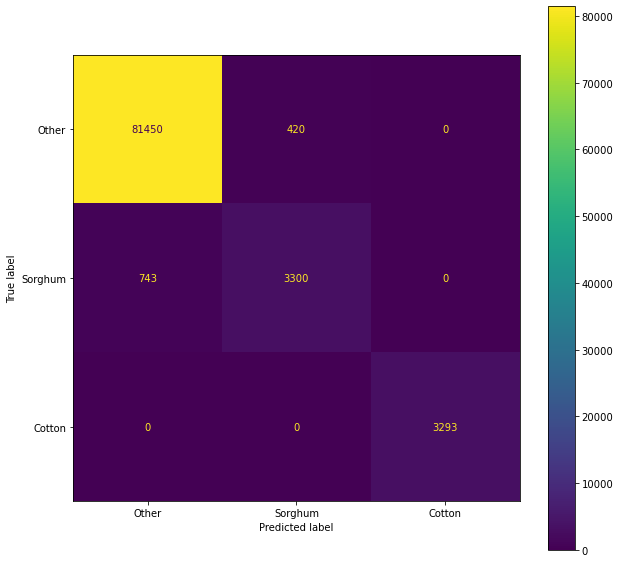

In [58]:
cm = confusion_matrix(y_test, rfc_pred, labels=rfc_best.classes_, normalize=None)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapper.values())
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

In [41]:
print(classification_report(y_test, rfc_pred, labels=rfc_best.classes_, target_names=label_mapper.values(), zero_division=0))

              precision    recall  f1-score   support

       Other       0.99      0.99      0.99     81870
     Sorghum       0.89      0.82      0.85      4043
      Cotton       1.00      1.00      1.00      3293

    accuracy                           0.99     89206
   macro avg       0.96      0.94      0.95     89206
weighted avg       0.99      0.99      0.99     89206



In [42]:
#knn
knn_pred = knn_best.predict(X_test)

In [43]:
cohen_kappa_score(y_test, knn_pred)

0.9117310500632783

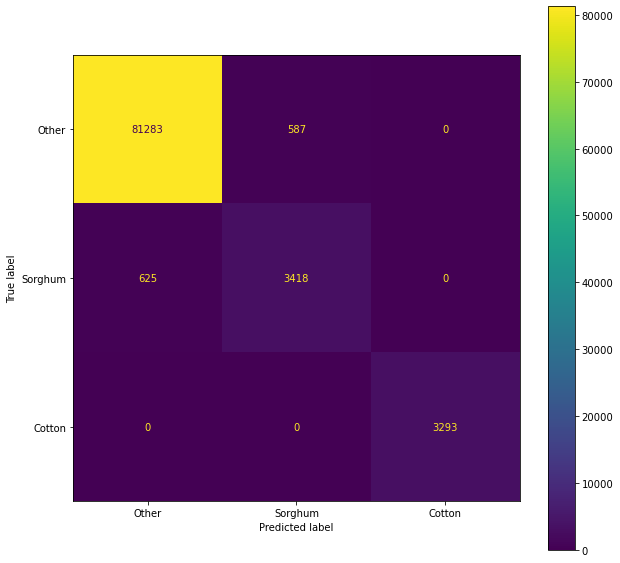

In [59]:
cm = confusion_matrix(y_test, knn_pred, labels=knn_best.classes_, normalize=None)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapper.values())
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

In [45]:
print(classification_report(y_test, knn_pred, labels=knn_best.classes_, target_names=label_mapper.values(), zero_division=0))

              precision    recall  f1-score   support

       Other       0.99      0.99      0.99     81870
     Sorghum       0.85      0.85      0.85      4043
      Cotton       1.00      1.00      1.00      3293

    accuracy                           0.99     89206
   macro avg       0.95      0.95      0.95     89206
weighted avg       0.99      0.99      0.99     89206



In [46]:
#mlp
mlp_pred = mlp_best.predict(X_test)

In [47]:
cohen_kappa_score(y_test, mlp_pred)

0.8393920581162213

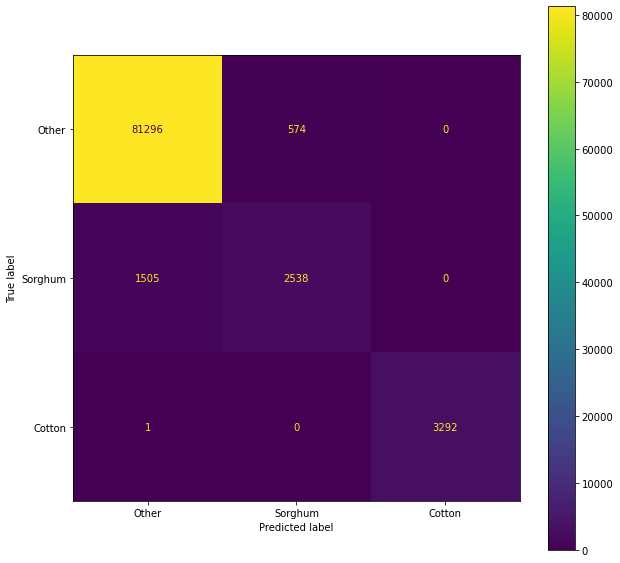

In [60]:
cm = confusion_matrix(y_test, mlp_pred, labels=mlp_best.classes_, normalize=None)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapper.values())
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

In [48]:
print(classification_report(y_test, mlp_pred, labels=mlp_best.classes_, target_names=label_mapper.values(), zero_division=0))

              precision    recall  f1-score   support

       Other       0.98      0.99      0.99     81870
     Sorghum       0.82      0.63      0.71      4043
      Cotton       1.00      1.00      1.00      3293

    accuracy                           0.98     89206
   macro avg       0.93      0.87      0.90     89206
weighted avg       0.97      0.98      0.98     89206

